In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

%matplotlib notebook

# Fit a visibility function to some results from fringes
This notebook gives an example of how to input some visibility data and fit a function to obtain a source size.

## We could manually enter the data into some arrays
The first set are from test data for the 2mm source.

In [2]:
# data           b1    b2   b3   b5   b6

# baseline lengths
b    = np.array([ 4,   1.9,   1, 0.7,   3]) * 1e-3

# visibilities
v_r = np.array([0.05,0.24, 0.68,0.77,0.07])
v_g = np.array([0.00,0.127,0.62,0.74,0.099])
v_b = np.array([0.01,0.008,0.46,0.69,0.16])

# wavelengths    b    v    r
lam = np.array([430, 520, 600]) * 1e-9

# get b/lambda (i.e. the x-axis values)
u_b = b/lam[0]
u_g = b/lam[1]
u_r = b/lam[2]

# combine
v_all = np.concatenate((v_r,v_g,v_b))
u_all = np.concatenate((u_r,u_g,u_b))

Data below are from the 3-hole images, see 3_hole notebook.

The measurements are currently garbage.

In [3]:
# wavelengths for red, green, blue
lam = np.array([638, 530, 448]) * 1e-9

b = np.array([0.5, 1, np.sqrt(0.5**2 + 1)]) * 1e-3

v_r = np.array([0.133, 0.151, 0.128])*3
v_g = np.array([0.107, 0.124, 0.088])*3
v_b = np.array([0.096, 0.105, 0.076])*3

# get b/lambda (i.e. the x-axis values)
u_b = b/lam[0]
u_g = b/lam[1]
u_r = b/lam[2]

# combine
v_all = np.concatenate((v_r,v_g,v_b))
u_all = np.concatenate((u_r,u_g,u_b))

## Or read from numpy save files
Here we have a list of fits files in a text file, each line has the baseline length in mm, the filter, and the file name. The code figures out from the path to the text file where the fits and save files are.

In [4]:
# textfile = '../testdata/single/files.txt'
textfile = '../testdata/single_2mm/files.txt'
path = os.path.dirname(textfile)

In [5]:
# wavelengths for red, green, blue
lam = np.array([638, 530, 448]) * 1e-9

In [6]:
u_all = np.array([])
v_all = np.array([])

for l in open(textfile, 'r'):
    
    # extract the info from the line
    b, filt, file = l.split(' ')
    file = file.rstrip()
    print(file)
    
    # convert filter name to wavelength
    if filt == 'r': wav = lam[0]
    if filt == 'g': wav = lam[1]
    if filt == 'b': wav = lam[2]
        
    # get b/lambda
    u_all = np.append(u_all, float(b)/wav/1e3)
    
    # uncomment one or other of below lines
    
    # get visibility from image fitting
    par = np.load(path + '/' + os.path.splitext(file)[0]+'-params.npy')
    vis = par[6]
    
    # or from saved FT results
#     vis = np.load(path + '/' + os.path.splitext(file)[0]+'-FTparams.npy')

    v_all = np.append(v_all, vis)

SrcC0.6B/200123_133026/2023-01-20-1330_4-U-G-Jup_0000.fits
SrcC0.6B/200123_133027/2023-01-20-1330_4-U-G-Jup_0000.fits
SrcC0.6G/200123_132912/2023-01-20-1329_2-U-G-Jup_0000.fits
SrcC0.6G/200123_132914/2023-01-20-1329_2-U-G-Jup_0000.fits
SrcC0.6R/200123_132305/2023-01-20-1323_0-U-G-Jup_0000.fits
SrcC0.6R/200123_132306/2023-01-20-1323_1-U-G-Jup_0000.fits
SrcC0.6R/200123_132308/2023-01-20-1323_1-U-G-Jup_0000.fits
SrcC1B/200123_133045/2023-01-20-1330_7-U-G-Jup_0000.fits
SrcC1B/200123_133046/2023-01-20-1330_7-U-G-Jup_0000.fits
SrcC1G/200123_132823/2023-01-20-1328_3-U-G-Jup_0000.fits
SrcC1G/200123_132824/2023-01-20-1328_4-U-G-Jup_0000.fits
SrcC1R/200123_132424/2023-01-20-1324_4-U-G-Jup_0000.fits
SrcC1R/200123_132425/2023-01-20-1324_4-U-G-Jup_0000.fits
SrcC1R/200123_132426/2023-01-20-1324_4-U-G-Jup_0000.fits
SrcC2B/200123_133112/2023-01-20-1331_2-U-G-Jup_0000.fits
SrcC2B/200123_133113/2023-01-20-1331_2-U-G-Jup_0000.fits
SrcC2G/200123_132800/2023-01-20-1328_0-U-G-Jup_0000.fits
SrcC2G/200123_132

## Now write a function that we will fit
The first function returns the absolute value of the visibility (we cannot measure negative values, and are not dealing with phases here) for some input parameters $p$, which are
- p[0]: the peak of the function at zero baseline, this might not be exactly 1
- p[1]: the angular size in radians of the source

The second function computes the $\chi^2$, though here we have no uncertainties on the visibility measurements so there is no denominator. This function uses the data `v_all` defined above, so this is a global variable and we do not need to pass it to the function.

In [7]:
def vis(p, u):
    return np.abs( 2 * p[0] * scipy.special.jv(1, np.pi*u*p[1]) / (np.pi*u*p[1]) )

def chi2_vis(p, u):
    return np.sum( (v_all - vis(p, u))**2 )

def vis_curve_fit(u, p0, p1):
    return vis( [p0, p1], u)

## Do the fitting
There are various minimisation codes we might use, some take a 'merit function' as input, such as one that computes a $\chi^2$, where others take a function that computes y values given some x. In choosing a function it's useful to use one that can incorporate uncertainties and give estimated uncertainties on the output parameters.

`scipy.optimize.minimize` takes as input the name of the function we are minimising (`chi2_vis`) and some initial guesses for the two parameters. It also takes the $b/\lambda$ values. It does not necessarily use uncertainties.

`scipy.optimize.curve_fit` takes a function that computes y values for a given x, can take uncertainties, and returns a covariance matrix. We can take the diagonal values of this matrix as estimates of the variance for each fitted paramter.

In [8]:
# run a first fit with minimize
r = scipy.optimize.minimize(chi2_vis, (1,0.0003), args=(u_all), method='Nelder-Mead')
fitted = r['x']

# print the best fit values, the first is the visiblity at zero baseline,
# the second the angular size of the source in radians
print(fitted)

[9.63128544e-01 2.49042252e-04]


### visibility uncertainties
With an initial fit, we can estimate uncertainties from the distribution of measurements around the best-fit model. This assumes that the uncertainty on every measurement is the same, which may not be true, but is empirical as long as the fit is a reasonably good approximation of reality is likely to be close to the real uncertainty.

In [9]:
unc = np.std(v_all - vis(fitted, u_all))
print(unc)

v_unc = np.repeat(unc, len(v_all))

0.01913140294328658


In [10]:
# now run a fit that incorporates uncertainties, starting from the previous fit
r = scipy.optimize.curve_fit(vis_curve_fit, u_all, v_all,
                             sigma=v_unc, absolute_sigma=True,
                             p0=fitted )

fitted = r[0]
uncertainty = np.sqrt(r[1].diagonal())

for i in [0,1]:
    print(f'{fitted[i]} +/- {uncertainty[i]}')

0.9630853880938781 +/- 0.006708644772739189
0.00024903691377183826 +/- 1.66416802208734e-06


### Diameter measurement
Now we can convert to a physical diameter at the distance between the front of the telescope and the source aperture. The uncertainty here comes out to be very small, perhaps unrealistically so.

In [11]:
# convert to actual size in mm, assuming distance of 7m
d = 8.4

print(f'{fitted[1] * d * 1e3:.3f} +/- {uncertainty[1] * d * 1e3:.3f} mm')

2.092 +/- 0.014 mm


## Plot the results
Here we plot the data and the best fit to the data to check things are sensible. We can also plot the residuals divided by the uncertainties, so the residuals are in units of standard deviations. If the distribution looks like it is approximately Gaussian with sigma=1 (bearing in mind that we do not have a lot of data), then everything is probably OK.

<IPython.core.display.Javascript object>


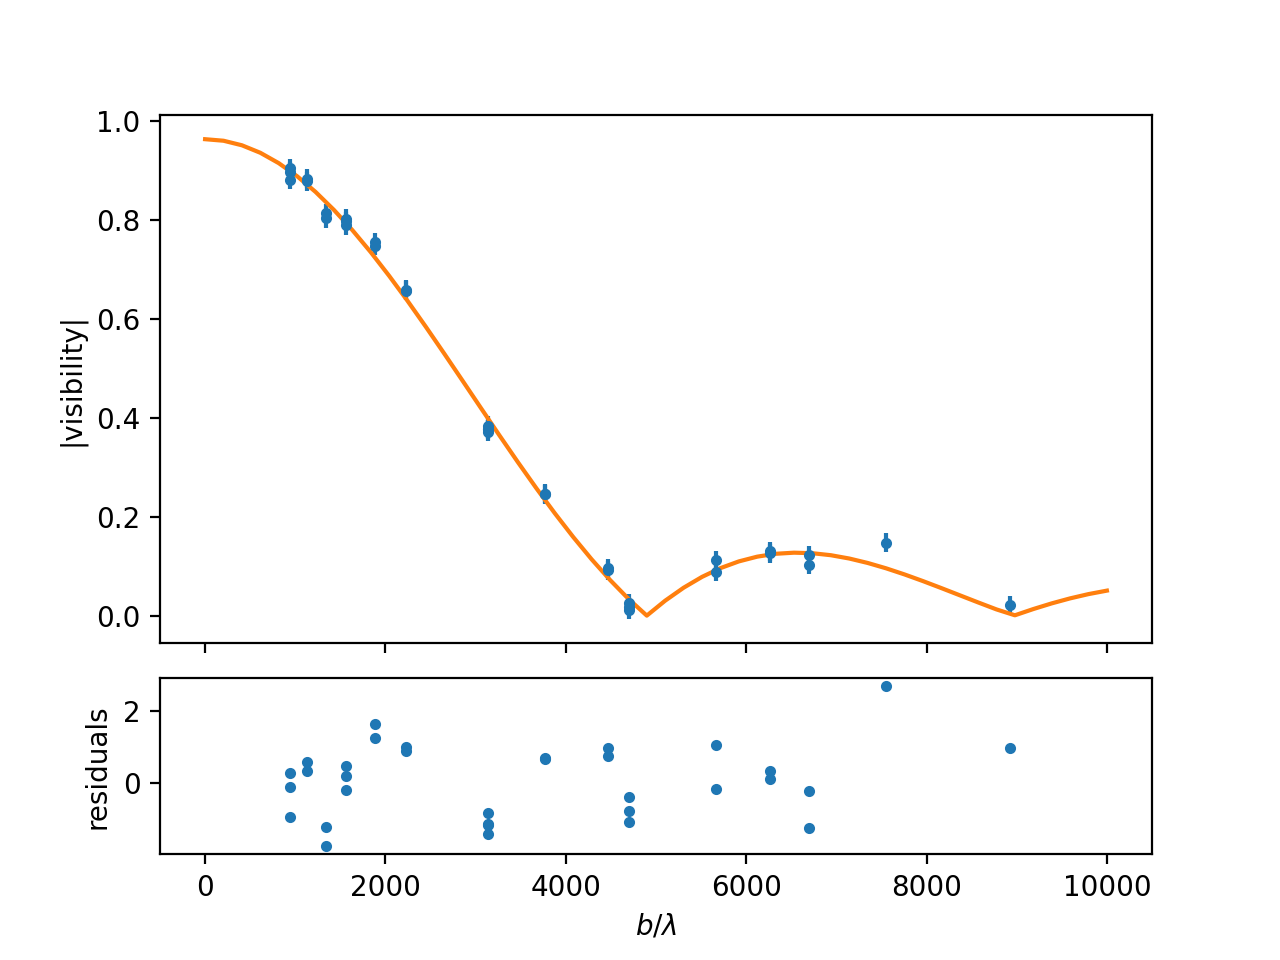

In [12]:
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
# ax[0].plot(u_r, v_r, '.r')
# ax[0].plot(u_g, v_g, '.g')
# ax[0].plot(u_b, v_b, '.b')
# ax[0].plot(u_all, v_all, 'o')
ax[0].errorbar(u_all, v_all, v_unc, fmt='.')

u = np.linspace(1, 1e4)
ax[0].plot(u, vis(fitted, u))

ax[1].plot(u_all, (v_all - vis(fitted, u_all))/unc, '.')

ax[1].set_xlabel('$b/\lambda$')
ax[0].set_ylabel('|visibility|')
ax[1].set_ylabel('residuals')
fig.subplots_adjust(hspace=0.1)

<IPython.core.display.Javascript object>


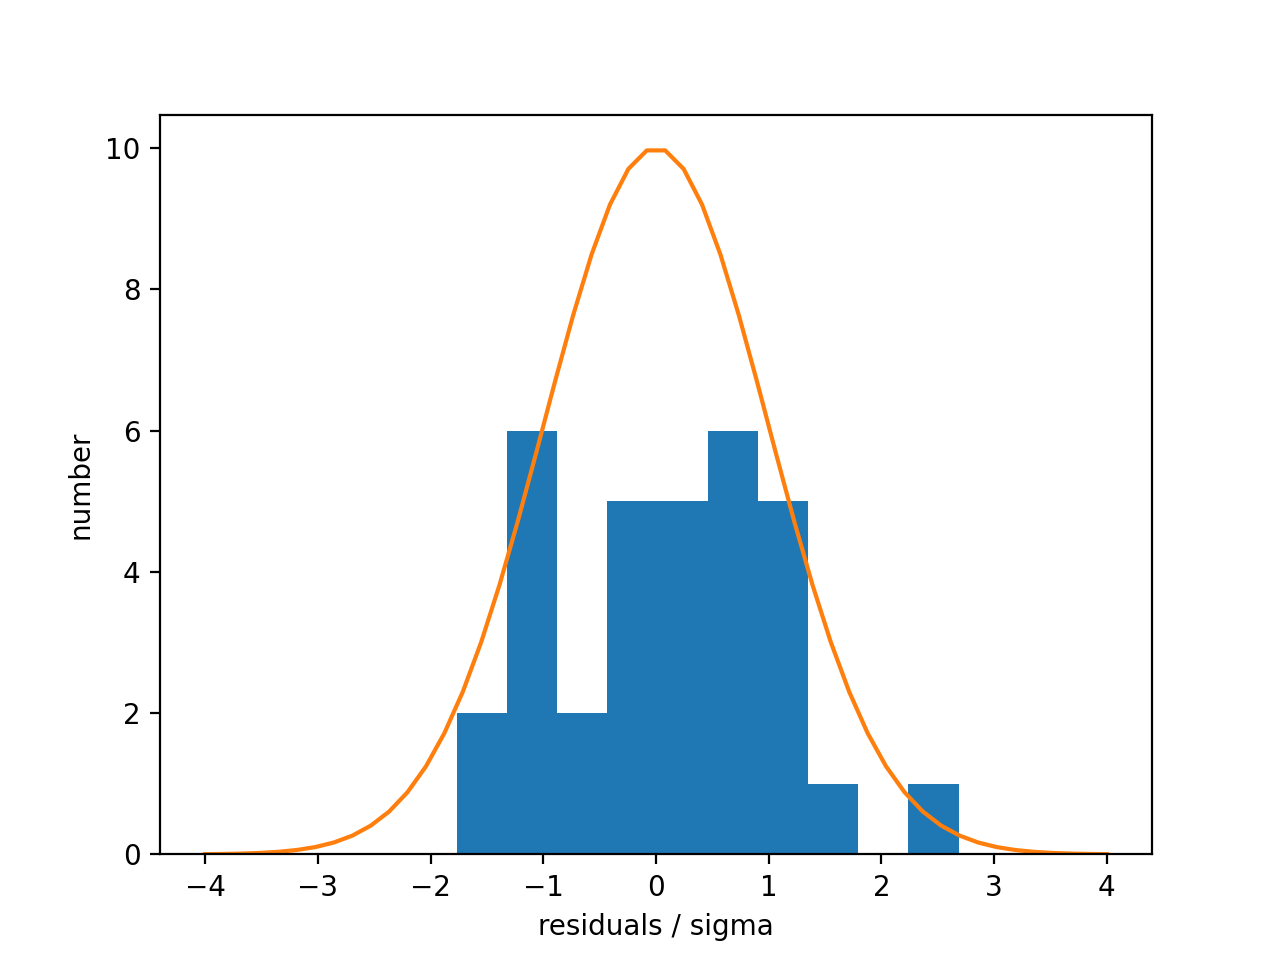

Text(0, 0.5, 'number')

In [13]:
fig, ax = plt.subplots()
ax.hist((v_all - vis(fitted, u_all))/unc, bins=10)

x = np.linspace(-4,4)
ax.plot(x, 10*np.exp(-0.5*x**2))

ax.set_xlabel('residuals / sigma')
ax.set_ylabel('number')